In [1]:
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import HistGradientBoostingClassifier
import plotly.express as px

In [2]:
mup =pd.read_feather("../muplus.feather") #read in mu plus feather file to pandas dataframe
print(f"Number of muplus events in data set is {len(mup)}")

ele = pd.read_feather("../electrons_large.feather") #read in electron feather to pandas
print(f"Number of electron events in data set is {len(ele)}")

mum = pd.read_feather("../muminus.feather") #read in mu minus file
print(f"Number of muminus events in data set is {len(mum)}")

pos = pd.read_feather("../positrons.feather") #read in positron file
print(f"Number of positron events in data set is {len(pos)}")

Number of muplus events in data set is 456616
Number of electron events in data set is 303723
Number of muminus events in data set is 468196
Number of positron events in data set is 35551


In [3]:
#create filtered dataframes containing only e-/+ and mu-/+. 

ele_filt = ele.loc[ele['pdg_id']==11]
pos1_filt = ele.loc[ele['pdg_id']==-11] 
mup_filt = mup.loc[mup['pdg_id']==-13]
pos2_filt = pos.loc[pos['pdg_id']==-11]
mum_filt = mum.loc[mum['pdg_id']==13]
pos_filt = pd.concat([pos1_filt, pos2_filt], ignore_index=True) #not many positron events in the file i had on disk, so add e+ events from the e- files.

In [4]:
print(ele_filt.shape,mup_filt.shape,pos_filt.shape,mum_filt.shape) #check to see dimensons of dataframes

(185244, 11) (394187, 11) (40333, 11) (390814, 11)


In [5]:
#combine the four dfs into one
combined_df = pd.concat([ele_filt, pos_filt, mup_filt, mum_filt], ignore_index=True)

#shuffle the combined df to randomize the entries
shuffled_df= combined_df.sample(frac = 1)
print(f"Number of shuffled events: {len(shuffled_df)}")

Number of shuffled events: 1010578


In [6]:
shuffled_df.head() #looking good

,energy,energy_cor,x,y,x_cor,y_cor,nhits,seed_e,seed_ix,seed_iy,pdg_id
708869,0.795304,0.912419,136.411377,38.978672,142.306137,38.120045,4,0.420932,7,2,13
17330,1.672606,1.862087,-245.315109,-40.883717,-251.286102,-39.234577,6,1.008465,-21,-2,11
479423,0.214460,0.295395,305.280365,-28.434490,293.603699,-44.856087,2,0.147862,20,-1,-13
434054,0.753119,0.847121,-260.529053,43.089962,-270.091187,42.484474,2,0.525096,-22,2,-13
728344,0.145775,0.217011,117.160355,29.302668,131.436340,27.511683,1,0.145775,6,1,13


In [7]:
#split shuffled dataframe into two: one for training, one for validation.

shuffled_training_df = shuffled_df.iloc[0:750000]
shuffled_validation_df = shuffled_df.iloc[750000:]
print(f"Number of total shuffled events for training: {len(shuffled_training_df)}")
print(f"Number of shuffled events for validation: {len(shuffled_validation_df)}")

Number of total shuffled events for training: 750000
Number of shuffled events for validation: 260578


In [8]:
for col in shuffled_training_df.columns:
    print(col)

energy
energy_cor
x
y
x_cor
y_cor
nhits
seed_e
seed_ix
seed_iy
pdg_id


In [9]:
#drop the redundant or truth features
#we drop the uncorrected features because the corrected features give better results later on.

train_df = shuffled_training_df.drop(columns=['x','y','energy']) 
val_df = shuffled_validation_df.drop(columns=['x','y','energy'])


In [10]:
#prepare four dataframes for sklearn's BD Tree:

X_train = train_df.drop(columns=['pdg_id']) #remove the 'truth' aka pdg_id column from the features dataset
X_test = val_df.drop(columns=['pdg_id']) #same thing, but for the df for testing the model
Y_train = train_df['pdg_id'] #this is the df containing the truth values for the X_train features, aka which particle they are
Y_test = val_df['pdg_id'] #contains truth values for the test set 

In [11]:
X_train.shape[0]==Y_train.shape[0] #sanity check

clf = tree.DecisionTreeClassifier() #create training function

In [167]:
%%time
#train!
clf.fit(X_train, Y_train)

CPU times: user 10.6 s, sys: 50 µs, total: 10.6 s
Wall time: 10.6 s


DecisionTreeClassifier()

In [168]:
clf_pred = clf.predict(X_test)

In [169]:
print("Training set score (should be very close to 1): %f" % clf.score(X_train, Y_train))
print("Test set score (how accurate the model is at classifying mu+/e-/mu-/e+): %f" % clf.score(X_test, Y_test))
print(f"So using {X_test.shape[0]} datapoints, we on average have a {(1-clf.score(X_test,Y_test))*100} % error at classifying 4 different kinds of particles")
clf_score = clf.score(X_test,Y_test)
clf_pruning_path = clf.cost_complexity_pruning_path(X_train, Y_train)
clf.get_params()

Training set score (should be very close to 1): 0.999177
Test set score (how accurate the model is at classifying mu+/e-/mu-/e+): 0.829395
So using 260578 datapoints, we on average have a 17.060534657568937 % error at classifying 4 different kinds of particles


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [170]:
print(clf_pruning_path)

{'ccp_alphas': array([ 0.00000000e+00, -8.47032947e-22,  0.00000000e+00, ...,
        1.93145488e-02,  2.83745736e-02,  1.67861582e-01]), 'impurities': array([0.00089838, 0.00089838, 0.00089838, ..., 0.43850482, 0.49525396,
       0.66311555])}


In [172]:
clf_feature_fig = px.bar(x = clf.feature_names_in_ ,y= clf.feature_importances_,labels=dict(x="Feature", y='Importance'), title = 'Feature Importances in Classification of e-/+,mu-/+. N_training =750,000 ')
clf_feature_fig.show()

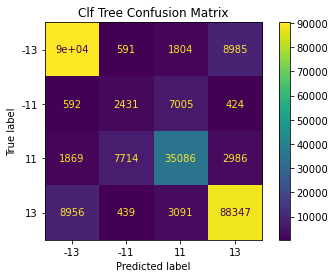

In [194]:
#create and plot the confusion matrix for the normal decision tree
clf_cmatrix = sklearn.metrics.confusion_matrix(Y_test, clf_pred, labels=clf.classes_)
clf_display = sklearn.metrics.ConfusionMatrixDisplay(clf_cmatrix, display_labels=clf.classes_)
clf_display.plot()
plt.title("Clf Tree Confusion Matrix")
plt.show()

In [17]:
%%time
hist_gradient_BC = HistGradientBoostingClassifier().fit(X_train,Y_train)

CPU times: user 1min 32s, sys: 468 ms, total: 1min 33s
Wall time: 12.2 s


In [149]:
hist_score = hist_gradient_BC.score(X_test,Y_test)
hist_pred = hist_gradient_BC.predict(X_test)
print(f"decision tree score: {clf_score}, hist gradient score: {hist_score}")
print(f"Hist gradient is: {100*(hist_score - clf_score)}) better than the basic decision tree")
hist_gradient_BC.get_params()

decision tree score: 0.8288381981594762, hist gradient score: 0.8838888931529139
Hist gradient is: 5.505069499343762) better than the basic decision tree


{'categorical_features': None,
 'class_weight': None,
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [157]:
hist_gradient_BC.n_iter_
hist_gradient_BC.feature_names_in_

array(['energy_cor', 'x_cor', 'y_cor', 'nhits', 'seed_e', 'seed_ix',
       'seed_iy'], dtype=object)

In [173]:
#no features_importances in hist gradient class, sadly 

#feature_fig = px.bar(x = hist_gradient_BC.feature_names_in_ ,y= hist_gradient_BC.feature_importances_,labels=dict(x="Feature", y='Importance'), title = 'Feature Importances in Classification of e-/+,mu-/+. N_training =750,000 ')
#feature_fig.show()

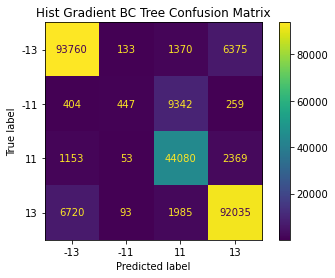

Hist gradient BC Tree shows significantly less confusion, but is surprisingly bad at identifying positrons


In [44]:
#create and plot the confusion matrix for the hist gradient boosted decision classifier 
hist_cmatrix = sklearn.metrics.confusion_matrix(Y_test, hist_pred,labels=hist_gradient_BC.classes_)
hist_display = sklearn.metrics.ConfusionMatrixDisplay(hist_cmatrix, display_labels=hist_gradient_BC.classes_)
hist_display.plot()
plt.title("Hist Gradient BC Tree Confusion Matrix")
plt.show()
print("Hist gradient BC Tree shows significantly less confusion, but is surprisingly bad at identifying positrons")

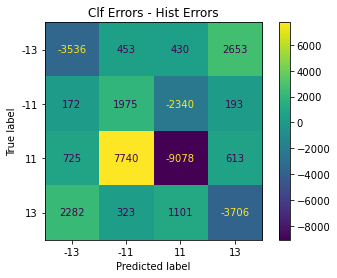

Negative numbers on the diag indicate better results with the Hist Gradient Tree, positive numbers on off diag indicate better results from CLF Tree
Positive numbers off diag indicate better results with Hist Gradient Tree, negative number on off diag indicate better results with CLF Tree 


In [54]:
cmatrix_diff = clf_cmatrix - hist_cmatrix
cmatrix_diff_display = sklearn.metrics.ConfusionMatrixDisplay(cmatrix_diff, display_labels=hist_gradient_BC.classes_)
cmatrix_diff_display.plot()
plt.title("Clf Errors - Hist Errors")
plt.show()
print("Negative numbers on the diag indicate better results with the Hist Gradient Tree, positive numbers on off diag indicate better results from CLF Tree")
print("Positive numbers off diag indicate better results with Hist Gradient Tree, negative number on off diag indicate better results with CLF Tree ")

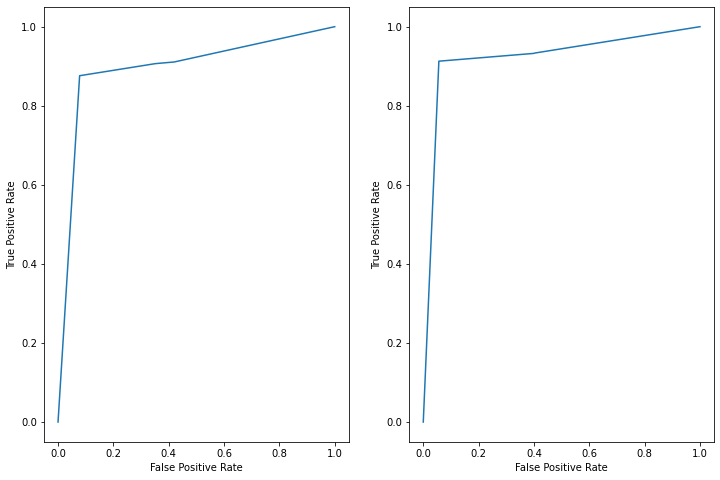

Particle pdg in plots is: 13


In [132]:
from sklearn.metrics import RocCurveDisplay, roc_curve
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))

i = clf.classes_[3] #change the index here to change particle used in plots

clf_fpr, clf_tpr, _ = roc_curve(Y_test, clf_pred, pos_label=i)
clf_roc_display = RocCurveDisplay(fpr=clf_fpr, tpr=clf_tpr)

hist_fpr, hist_tpr, _ = roc_curve(Y_test, hist_pred, pos_label=i)
hist_roc_display = RocCurveDisplay(fpr=hist_fpr, tpr=hist_tpr)
   
clf_roc_display.plot(ax=ax1)
hist_roc_display.plot(ax=ax2)
plt.show()
print(f"Particle pdg in plots is: {i}")

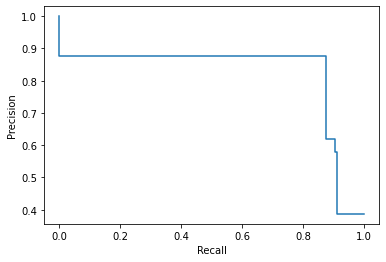

In [138]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
prec, recall, _ = precision_recall_curve(Y_test, clf_pred, pos_label=clf.classes_[3])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [162]:
%%time #warning, takes quite a while!
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train, Y_train)

CPU times: user 5min 17s, sys: 1.05 s, total: 5min 18s
Wall time: 5min 18s


RandomForestClassifier()

In [161]:
forest_score = forest.score(X_test,Y_test)
forest_pred = forest.predict(X_test)
print(f"decision forest score: {forest_score}, hist gradient score: {hist_score}")
print(f"decision forest is: {100*(forest_score - hist_score)} better than the hist gradient method")
forest.get_params()

decision forest score: 0.8759987412598147, hist gradient score: 0.8838888931529139
decision forest is: -0.7890151893099162 better than the hist gradient method


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

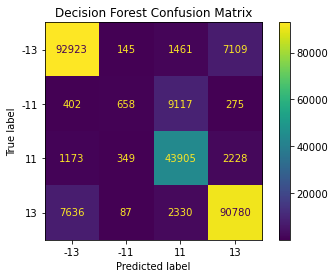

In [163]:
forest_cmatrix = sklearn.metrics.confusion_matrix(Y_test, forest_pred,labels=forest.classes_)
forest_display = sklearn.metrics.ConfusionMatrixDisplay(forest_cmatrix, display_labels=forest.classes_)
forest_display.plot()
plt.title("Decision Forest Confusion Matrix")
plt.show()

In [164]:
forest_feature_fig = px.bar(x = forest.feature_names_in_ ,y= forest.feature_importances_,labels=dict(x="Feature", y='Importance'), title = 'Feature Importances in Classification of e-/+,mu-/+. N_training =750,000 ')
forest_feature_fig.show()

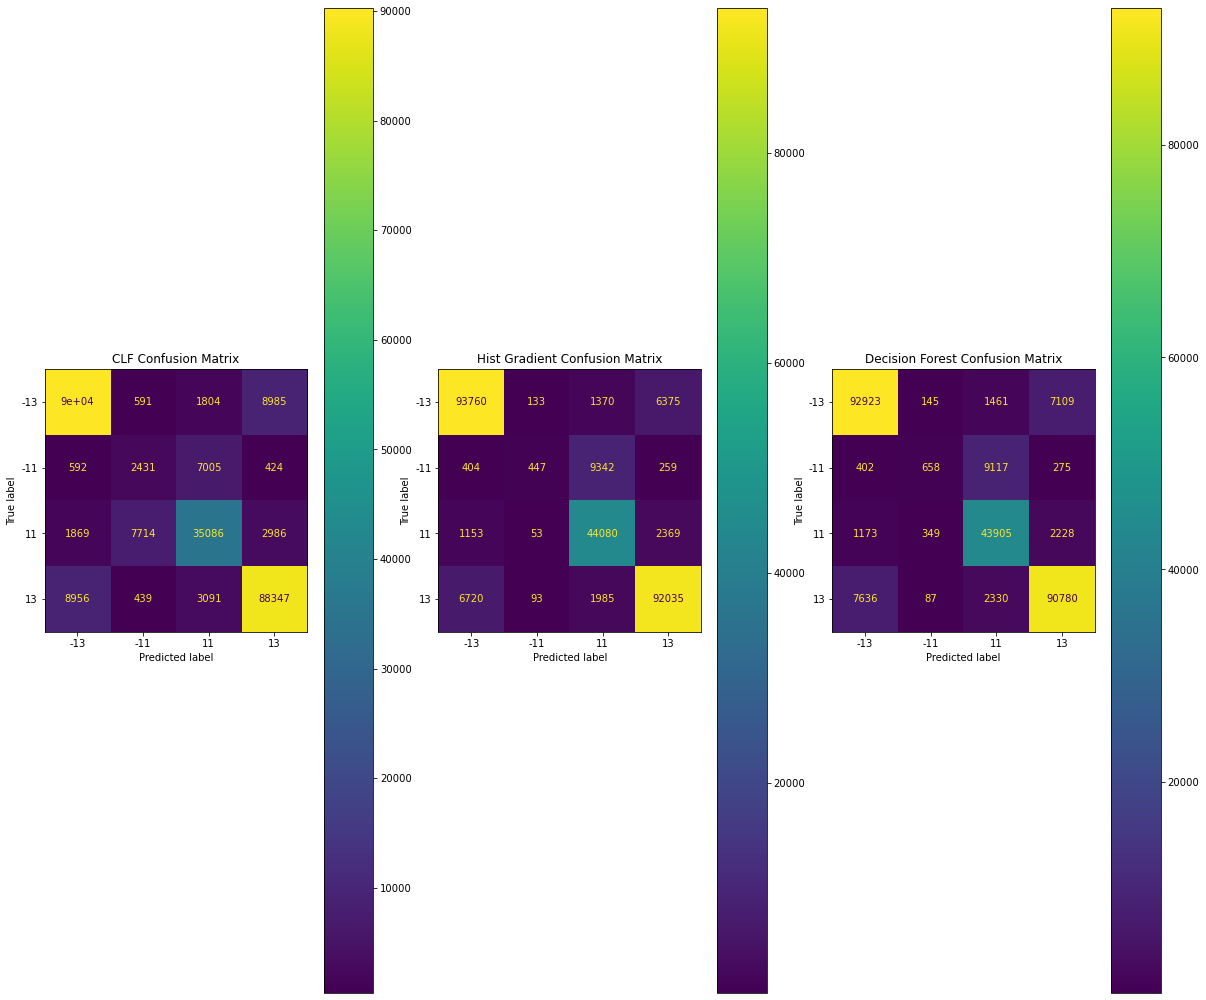

In [201]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,20 ))

clf_display.plot(ax=ax1)
ax1.title.set_text('CLF Confusion Matrix')
hist_display.plot(ax=ax2)
ax2.title.set_text('Hist Gradient Confusion Matrix')
forest_display.plot(ax=ax3)
ax3.title.set_text('Decision Forest Confusion Matrix')


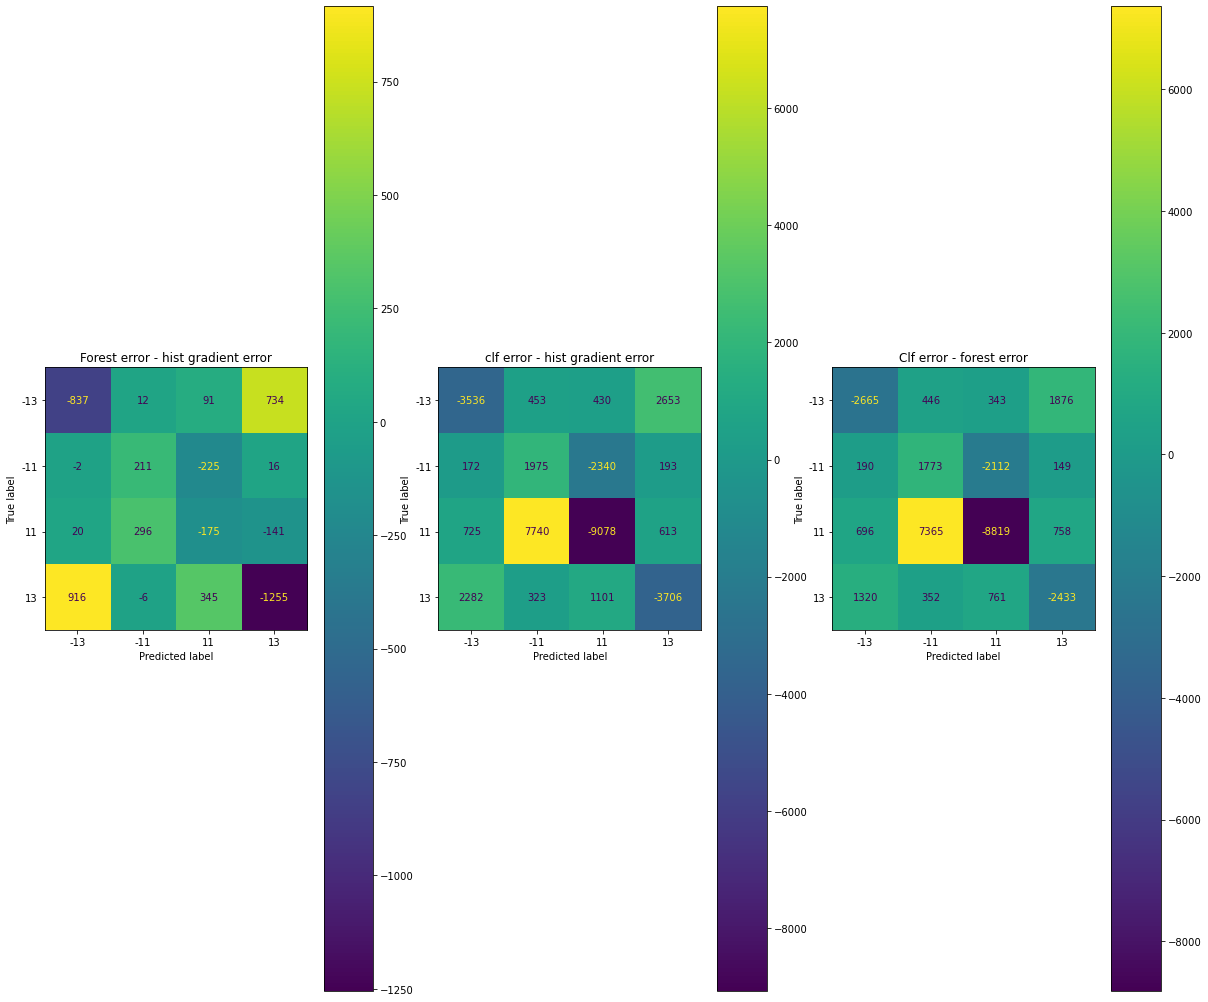

Negative numbers on the diag indicate better results with the latter model, positive numbers on off diag indicate better results from former model
Positive numbers off diag indicate better results with latter model, negative number on off diag indicate better results with former model 


In [202]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,20 ))


cmatrix_diff_forest = forest_cmatrix - hist_cmatrix
cmatrix_diff_forest_display = sklearn.metrics.ConfusionMatrixDisplay(cmatrix_diff_forest, display_labels=hist_gradient_BC.classes_)
cmatrix_diff_forest_display.plot(ax=ax1)
ax1.title.set_text('Forest error - hist gradient error')
cmatrix_diff_display.plot(ax=ax2)
ax2.title.set_text('clf error - hist gradient error')

cmatrix_diff_clf_forest = clf_cmatrix - forest_cmatrix 
cmatrix_diff_clf_forest_display = sklearn.metrics.ConfusionMatrixDisplay(cmatrix_diff_clf_forest, display_labels=clf.classes_)
cmatrix_diff_clf_forest_display.plot(ax=ax3)
ax3.title.set_text('Clf error - forest error')


plt.show()
print("Negative numbers on the diag indicate better results with the latter model, positive numbers on off diag indicate better results from former model")
print("Positive numbers off diag indicate better results with latter model, negative number on off diag indicate better results with former model ")

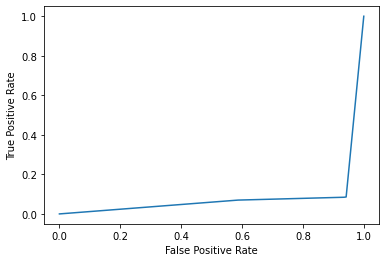

In [208]:
forest_fpr, forest_tpr, _ = roc_curve(Y_test, forest_pred, pos_label=forest.classes_[0])
forest_roc_display = RocCurveDisplay(fpr=forest_fpr, tpr=forest_tpr)
forest_roc_display.plot()

In [211]:
%%time #"An AdaBoost [1] classifier is a meta-estimator that begins by fitting a classifier
#on the original dataset and then fits additional copies of the classifier on the same dataset
#but where the weights of incorrectly classified instances are adjusted such that subsequent 
#classifiers focus more on difficult cases."
from sklearn.ensemble import AdaBoostClassifier

ada=AdaBoostClassifier()
ada.fit(X_train,Y_train)
ada_score = ada.score(X_test,Y_test)
ada_pred = ada.predict(X_test)

CPU times: user 52.9 s, sys: 389 ms, total: 53.3 s
Wall time: 53.3 s


In [212]:
print(f"ada score is : {ada_score}, hist gradient score: {hist_score}")
print(f"ada is: {100*(ada_score - hist_score)} better than the hist gradient method")

ada score is : 0.7549639647245738, hist gradient score: 0.8838888931529139
ada is: -12.892492842834002 better than the hist gradient method


In [216]:
%%time #WARNING, TAKES A VERY LONG TIME
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier()
grad.fit(X_train, Y_train)
grad_score = grad.score(X_test,Y_test)
grad_predict = grad.predict(X_test)
print(f"grad score is : {grad_score}, hist gradient score: {hist_score}")
print(f"grad is: {100*(grad_score - hist_score)} better than the hist gradient method")

grad score is : 0.8463262439653386, hist gradient score: 0.8838888931529139
grad is: -3.7562649187575237 better than the hist gradient method
CPU times: user 15min 13s, sys: 1.13 s, total: 15min 14s
Wall time: 15min 14s


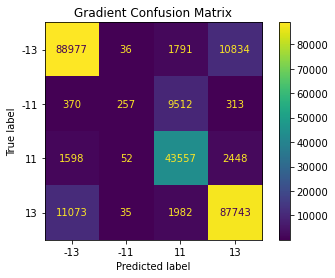

In [218]:
grad_cmatrix = sklearn.metrics.confusion_matrix(Y_test, grad_predict,labels=grad.classes_)
grad_display = sklearn.metrics.ConfusionMatrixDisplay(grad_cmatrix, display_labels=grad.classes_)
grad_display.plot()
plt.title("Gradient Confusion Matrix")
plt.show()

gradient vs hist method is very closely related, and this is reflected in the erorr matrix.


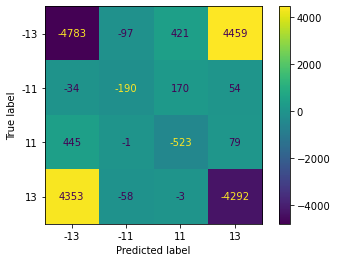

In [220]:
grad_hist_diff_cmatrix = grad_cmatrix - hist_cmatrix
grad_hist_diff_display = sklearn.metrics.ConfusionMatrixDisplay(grad_hist_diff_cmatrix, display_labels=grad.classes_)
grad_hist_diff_display.plot()
print("gradient vs hist method is very closely related, and this is reflected in the erorr matrix.")

In [223]:
grad_feature_fig = px.bar(x = grad.feature_names_in_ ,y= grad.feature_importances_,labels=dict(x="Feature", y='Importance'), title = 'Feature Importances of Gradient Method in Classification of e-/+,mu-/+. N_training =750,000 ')
grad_feature_fig.show()

In [ ]:
#conclusions so far: hist gradient method and decision forests are promising and almost comparable in accuracy,
#while the standard decision tree (clf) is roughy 5% behind in this multi-class classification exploration
#the positrons seem to be the hardest for these methods to detect, and the standard decision tree is significantly better than
#the two more sophisticated methods, interestingly.
#the mu plus vs mu minus throws the highest amount of false positives / mislabeling for all three methods here. 
#hist gradient method is way way faster (as advertised, 12s vs 5mins) than the forest method, and is roughly 1% more accurate than the forest.